# ColumbiaX-03-Clustering

## Set Up Session

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

## Data Generation

In [2]:
# Config:
K = 5

In [3]:
# Class prior--Dirichlet distribution:
prior = np.random.dirichlet(np.ones(K))

In [4]:
# Sample generation--mus:
mu = np.asarray(
    [
        [6.0*np.cos(i*2*np.pi/K), 8.0*np.sin(i*2*np.pi/K)] for i in xrange(K)
    ]
)

In [5]:
# Sample generation--cov mats:
cov = np.asarray(
    [
        #np.matmul(x.T, x) for x in (0.618*np.random.randn(2, 2)+1 for _ in xrange(K))
        np.eye(2) for _ in xrange(K)
    ]
)

In [6]:
# Number of samples:
N = 2000

In [7]:
# Generate sample classes:
classes = np.random.multinomial(N, prior)

In [8]:
# Generate sample features:
X = np.concatenate(
    tuple(
        np.random.multivariate_normal(mean=mu[i], cov=cov[i], size = classes[i]) for i in xrange(K)
    )
)
y = np.concatenate(
    tuple(
        i*np.ones(classes[i]) for i in xrange(K)
    )
).astype(np.int)

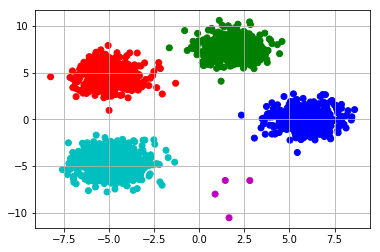

In [9]:
# Visualize:
import matplotlib.pyplot as plt
# Scatter plot:
plt.scatter(
    X[:, 0], X[:, 1], 
    color = np.asarray(
        ['b', 'g', 'r', 'c', 'm', 'y']
    )[y]
)
plt.grid()
plt.show()

In [10]:
# Save data for command-line application:
import pandas as pd

pd.DataFrame(data = X).to_csv('X.csv', index=False, header=False)
pd.DataFrame(data = y).to_csv('y.csv', index=False, header=False)

In [11]:
# Max iterations:
MAX_ITER = 10

## K-Means

$$
\mathcal{L} = \sum_{i=1}^n \sum_{k=1}^K \boldsymbol{1}(c_i = k)\|x_i - \mu_k\|^2.
$$

In [12]:
# Utilities:
def k_means_init(X, K):
    """ Generate initial means for K means clustering
    """
    '''
    # Random initialize:
    mu_idx = np.random.choice(X.shape[0], size=K, replace=False)
    return X[mu_idx]    
    '''
    # Perfect initialize:
    return np.concatenate(
        tuple(
            X[np.argmax(y==class_idx)] for class_idx in xrange(K)
        )
    ).reshape((-1, 2))
def k_means_assign(X, mu, K):
    """ Expectation
    """
    return np.argmin(
        np.column_stack(
            tuple(
                np.sum((X-mu[class_idx])**2, axis=1) for class_idx in xrange(K)
            )
        ),
        axis = 1
    )
def k_means_update(X, assignment, K):
    """ Maximization
    """
    return np.asarray(
        [np.mean(X[assignment == class_idx], axis = 0) for class_idx in xrange(K)]
    )

In [13]:
# Initialize:
k_means_mu = k_means_init(X, K)

In [14]:
for epoch in xrange(MAX_ITER):
    # Assignment:
    k_means_assignment = k_means_assign(X, k_means_mu, K)
    # Update:
    k_means_mu = k_means_update(X, k_means_assignment, K)
    # Centroids output: 
    with open(
        "centroids-{iteration}.csv".format(iteration = epoch+1), 
        "w"
    ) as centroids_output:
        centroids_output.write(
            "\n".join(
                ",".join(str(x) for x in mu) for mu in k_means_mu
            )
        )

In [15]:
# Finally:
k_means_assignment = k_means_assign(X, k_means_mu, K)

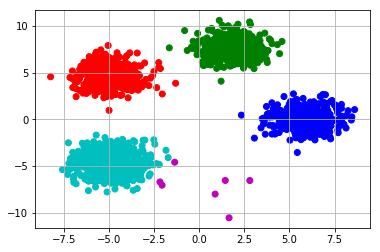

In [16]:
# Visualize:
import matplotlib.pyplot as plt
# Scatter plot:
plt.scatter(
    X[:, 0], X[:, 1], 
    color = np.asarray(
        ['b', 'g', 'r', 'c', 'm', 'y']
    )[k_means_assignment]
)
plt.grid()
plt.show()

## EM-GMM

The generative assumption is as follows:

$$
x_i |c_i \sim Normal(\mu_{c_i},\Sigma_{c_i}),\quad c_i \sim Discrete(\pi).
$$

We use EM to maximize the following objective:

$$
p(x_1,\dots,x_n|\pi,\boldsymbol{\mu},\boldsymbol{\Sigma}) = \prod_{i=1}^n p(x_i|\pi,\boldsymbol{\mu},\boldsymbol{\Sigma})
$$

In [17]:
# Utilities:
def em_init(X, K):
    """ Generate initial means for EM-GMM
    """
    # 0. Dataset configuration:
    N, D = X.shape
    # 1. prior:
    prior = np.ones(K) / K
    # 2. mu--random
    # mu = X[np.random.choice(N, size=K, replace=False)]
    # 2. mu--perfect:
    mu = np.concatenate(
        tuple(
            X[np.argmax(y==class_idx)] for class_idx in xrange(K)
        )
    ).reshape((-1, 2))
    # 3. cov
    cov = np.asarray(
        [np.eye(D) for _ in xrange(K)]
    )
    return (prior, mu, cov)

In [18]:
# Init:
N, D = X.shape
em_prior, em_mu, em_cov = em_init(X, K)

In [19]:
for epoch in xrange(MAX_ITER):
    # Likelihood:
    em_likelihood = [
        multivariate_normal(mean=em_mu[class_idx], cov=em_cov[class_idx]) for class_idx in xrange(K)
    ]
    # Posterior:
    em_posterior = np.column_stack(
        tuple(
            em_prior[class_idx]*em_likelihood[class_idx].pdf(X)for class_idx in xrange(K)
        )
    )
    em_posterior = np.matmul(
        np.diag(1.0 / em_posterior.sum(axis=1)),
        em_posterior
    )
    # 
    em_equivalent_n = np.sum(
        em_posterior, axis = 0
    )
    # Expectation:
    em_prior = em_equivalent_n / N
    # Maximization:
    em_mu = np.asarray(
        [
            np.average(
                X,
                axis = 0,
                weights = em_posterior[:, class_idx]
            ) for class_idx in xrange(K)
        ]
    )
    em_cov = np.asarray(
        [
            1.0 / em_equivalent_n[class_idx] * np.matmul(
                (X - em_mu[class_idx]).T,
                np.matmul(
                    np.diag(em_posterior[:, class_idx]),
                    (X - em_mu[class_idx])
                )
            ) for class_idx in xrange(K)
        ]
    )
    # Priors output:
    with open(
        "pi-{iteration}.csv".format(iteration = epoch+1), 
        "w"
    ) as pi_output:
        pi_output.write(
            "\n".join(str(x) for x in em_prior)
        )
    # Means output:
    with open(
        "mu-{iteration}.csv".format(iteration = epoch+1), 
        "w"
    ) as mu_output:
        mu_output.write(
            "\n".join(
                ",".join(str(x) for x in mu) for mu in em_mu
            )
        )
    # Covariance matrices output:
    for class_idx in xrange(K):
        with open(
            "Sigma-{cluster}-{iteration}.csv".format(
                cluster = class_idx+1, 
                iteration = epoch+1
            ), 
            "w"
        ) as cov_output:
            cov_output.write(
                "\n".join(
                    ",".join(str(x) for x in xs) for xs in em_cov[class_idx]
                )
            ) 

In [20]:
# Make predictions using Bayesian classifer:
bayesian_likelihood = [
    multivariate_normal(mean=em_mu[class_idx], cov=em_cov[class_idx]) for class_idx in xrange(K)
]
bayesian_posterior = np.column_stack(
    tuple(
        em_prior[class_idx]*bayesian_likelihood[class_idx].pdf(X) for class_idx in xrange(K)
    )
)
bayesian_posterior = np.matmul(
    np.diag(1.0 / bayesian_posterior.sum(axis=1)),
    bayesian_posterior
)
# Predict using Bayesian classifier:
em_assignment = np.argmax(bayesian_posterior, axis = 1)

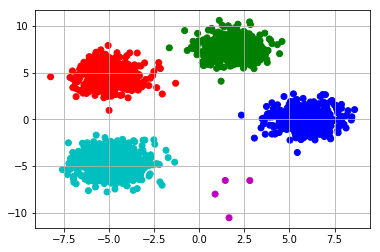

In [21]:
# Visualize:
import matplotlib.pyplot as plt
# Scatter plot:
plt.scatter(
    X[:, 0], X[:, 1], 
    color = np.asarray(
        ['b', 'g', 'r', 'c', 'm', 'y']
    )[em_assignment]
)
plt.grid()
plt.show()